## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap08/input/data-salary-3.txt')
df.head()

,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


## サンプルデータの散布図行列

In [3]:
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=31):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)
   
    def diag(self, series, label=None, color=None):
        """ 対角部分のプロット """

        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

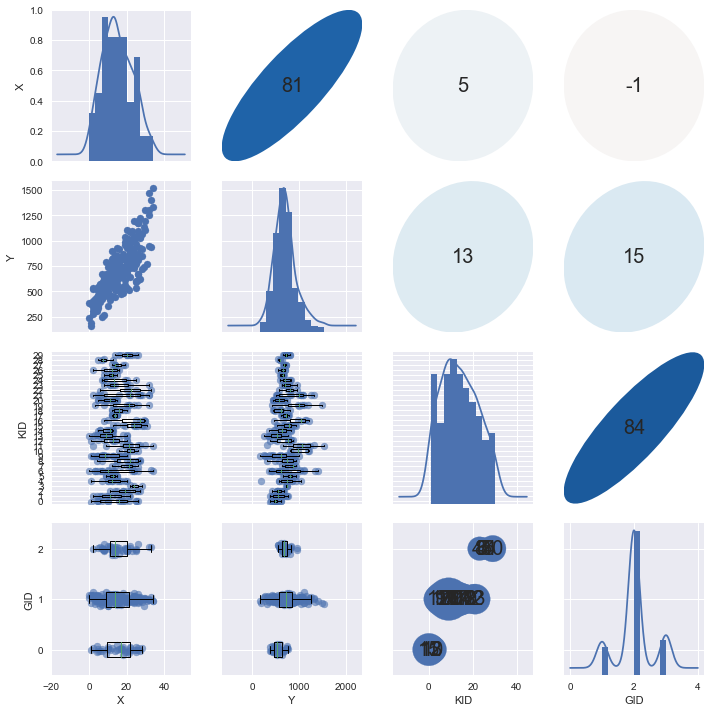

In [4]:
g = sns.PairGrid(df, diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb);
# 上三角成分
g.map_upper(d.ellipse);

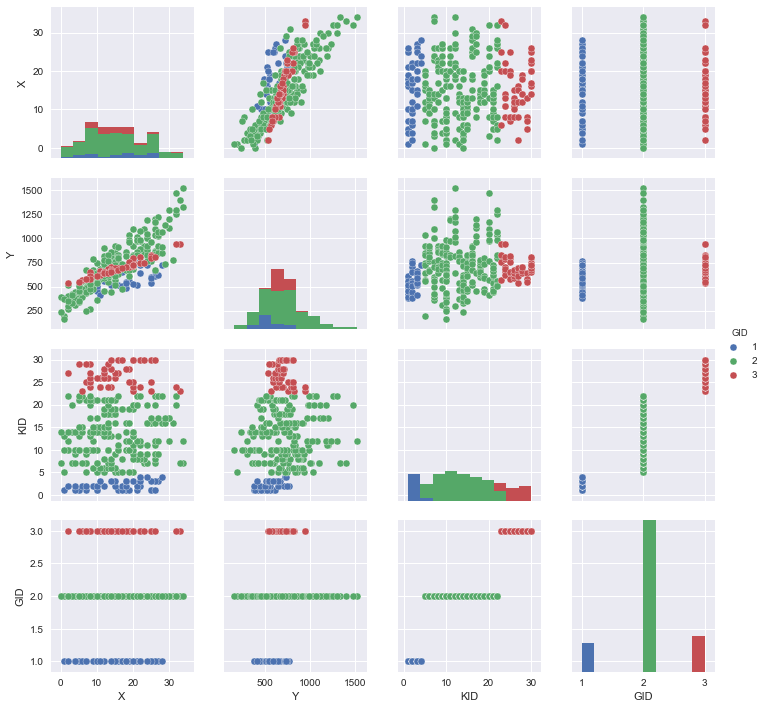

In [5]:
sns.pairplot(data=df, hue='GID')

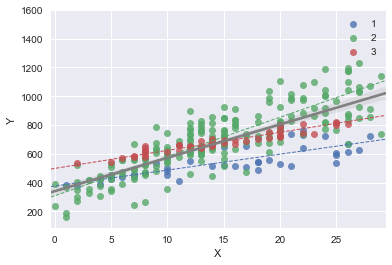

In [6]:
plt.figure()
for KID, df_sub, in df.groupby(by="GID"):
    sns.regplot(x=df_sub.X, y=df_sub.Y, label=KID, 
                ci=0, line_kws={"linestyle":"--", "linewidth":1.0})
sns.regplot(x=df.X, y=df.Y, scatter=False, ci=95, line_kws={"color":"gray"})
plt.legend()
plt.show()

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

intercept = []
slope = []
gid =[]

for ID, df_sub in df.groupby(by=['GID', 'KID']):
    res_lm = smf.ols(formula='Y ~ X', data=df_sub).fit()
    intercept.append(res_lm.params[0])
    slope.append(res_lm.params[1])
    gid.append(ID[0])

df_lm = pd.DataFrame(data=dict(Intercept=intercept, Slope=slope, GID=gid))

C:\Users\eX\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


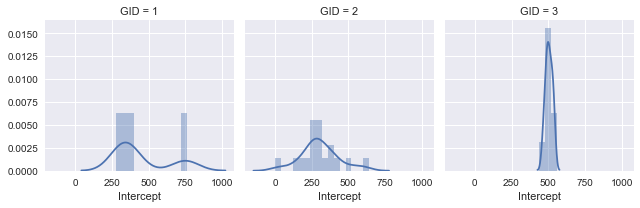

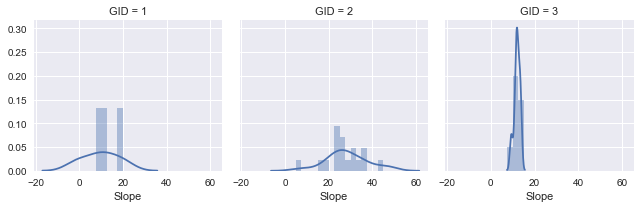

In [33]:
plt.figure()
bins = np.arange(0, 800, 800/20)
g=sns.FacetGrid(df_lm, col="GID")
g=g.map(sns.distplot, "Intercept", bins=bins)
plt.show()

plt.figure()
bins = np.arange(0, 50, 50/20)
g=sns.FacetGrid(df_lm, col="GID")
g=g.map(sns.distplot, "Slope", bins=bins)
plt.show()

## メカニズム１：a, b の平均は業界によって異なるが、a, b のバラツキは業界を問わず一定とする

$ a_{avg}[g] $ ~ $ Normal(a_{avg\_all}, \sigma_{ag}) $

$ b_{avg}[g] $ ~ $ Normal(b_{avg\_all}, \sigma_{bg}) $

$a[k]$ ~ $ Normal(a_{avg}[GID[g]], \sigma_a)$

$b[k]$ ~ $ Normal(b_{avg}[GID[g]], \sigma_b)$

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma_y )$

$g = 1, ..., G$

$k = 1, ..., K$

$n = 1, ..., N$

In [35]:
model_code="""
data {
  int G;
  int K;
  int N;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=G> K2G[K];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real aavg_all;
  real bavg_all;
  real aavg[G];
  real bavg[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_y;
}
model {
  for (g in 1:G) {
    aavg[g] ~ normal(aavg_all, s_ag);
    bavg[g] ~ normal(bavg_all, s_bg);
  }
  for (k in 1:K) {
    a[k] ~ normal(aavg[K2G[k]], s_a);
    b[k] ~ normal(bavg[K2G[k]], s_b);  
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], s_y);
}
"""

from pystan import StanModel

K2G = df[~df[['KID', 'GID']].duplicated()].GID
data = dict(N=df.shape[0], G=df.GID.nunique(), K=df.KID.nunique(), X=df.X, K2G=K2G, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=1234)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b8866c67f9f8304959b334edb363f1c3 NOW.


Inference for Stan model: anon_model_b8866c67f9f8304959b334edb363f1c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aavg_all 311.87   50.09 812.27 -788.2 289.52 384.53 473.78 1164.3    263   1.01
bavg_all  20.59    4.37  83.74  -54.2  10.85  18.41  25.38 121.64    368    1.0
aavg[0]  360.37     0.8  29.11 303.37  340.7 360.68 379.85 417.68   1334    1.0
aavg[1]  298.73    0.48  14.13 270.15 289.67 298.86  307.8 326.66    880    1.0
aavg[2]  498.78    1.05  28.75 441.66 479.56 498.98  518.1 554.61    747    1.0
bavg[0]   13.09    0.06   2.74   7.68  11.25  13.02  14.93  18.59   2297    1.0
bavg[1]    28.6    0.03   1.41  25.72  27.68  28.59   29.5  31.43   1814    1.0
bavg[2]   12.53    0.07   2.47   7.67   10.9  12.59  14.14  17.39   1115    1.0
a[0]     365.72    0.69   26.7 315.01  347.4 366.42 384.08 418.56   1507    1.0
a[1]     35

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


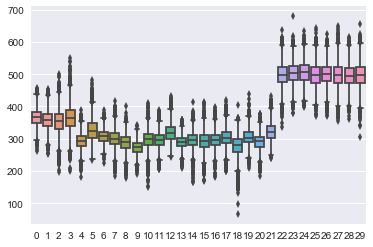

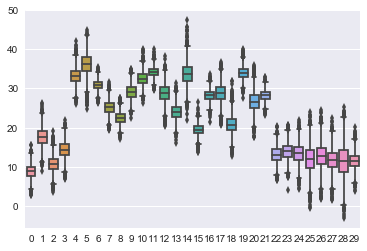

In [36]:
sns.boxplot(data=fit.extract()['a'])
plt.show()
sns.boxplot(data=fit.extract()['b'])
plt.show()

## メカニズム２：a, b の平均も、a, b のバラツキも業界によって異なる

$ a_{avg}[g] $ ~ $ Normal(a_{avg\_all}, \sigma_{ag}) $

$ b_{avg}[g] $ ~ $ Normal(b_{avg\_all}, \sigma_{bg}) $

$a[k]$ ~ $ Normal(a_{avg}[GID[g]], \sigma_a[GID[g]])$

$b[k]$ ~ $ Normal(b_{avg}[GID[g]], \sigma_b[GID[g]])$

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma_y[GID[g]] )$

$g = 1, ..., G$

$k = 1, ..., K$

$n = 1, ..., N$

In [30]:
model_code="""
data {
  int G;
  int K;
  int N;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=G> GID[N];
  int<lower=1,upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
}
parameters {
  real aavg_all;
  real bavg_all;
  real aavg[G];
  real bavg[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a[G];
  real<lower=0> s_b[G];
  real<lower=0> s_y[G];
}
model {
  for (g in 1:G) {
    aavg[g] ~ normal(aavg_all, s_ag);
    bavg[g] ~ normal(bavg_all, s_bg);
  }
  for (k in 1:K) {
    a[k] ~ normal(aavg[K2G[k]], s_a[K2G[k]]);
    b[k] ~ normal(bavg[K2G[k]], s_b[K2G[k]]);  
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], s_y[GID[n]]);
}
"""

from pystan import StanModel

K2G = df[~df[['KID', 'GID']].duplicated()].GID
data = dict(N=df.shape[0], G=df.GID.nunique(), K=df.KID.nunique(), X=df.X, K2G=K2G, KID=df.KID, GID=df.GID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0d8120b898d744c4927d0cba9bdbdc44 NOW.


Inference for Stan model: anon_model_0d8120b898d744c4927d0cba9bdbdc44.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aavg_all 747.76  260.91 1826.3 -234.9 310.25 404.05 503.15 6074.5     49   1.08
bavg_all  22.71    3.52  57.95 -52.41  10.77  18.26  25.77 130.45    271   1.01
aavg[0]  381.04    4.11 106.66 228.09 342.09 372.71  412.1 589.15    674    1.0
aavg[1]  300.38    0.61  17.34 266.69  289.1 299.94 311.49 335.37    812   1.01
aavg[2]  500.62    0.39  10.48 479.11 494.24 501.06 507.11 521.62    709   1.01
bavg[0]   12.82    0.19   6.41  -0.22  10.03  12.83  15.56  25.81   1157    1.0
bavg[1]    28.5    0.04   1.67  25.25  27.45  28.46  29.62  31.75   1650    1.0
bavg[2]   12.37    0.02   0.58  11.14  12.01  12.42  12.77  13.37   1424    1.0
a[0]     383.15    0.31  14.74  354.3 373.61 383.06 392.99 411.53   2236    1.0
a[1]     33